In [ ]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 33.1 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp "/content/drive/MyDrive/LC08_L1GT_004001_20240101_20240112_02_T2.tar" .

In [ ]:
!mkdir -p extracted_scene
!tar -xf LC08_L1GT_004001_20240101_20240112_02_T2.tar -C extracted_scene

**BAND READING & PREPROCESSING**

In [ ]:
import rasterio
import numpy as np
import glob
import matplotlib.pyplot as plt

files = glob.glob("extracted_scene/*.TIF")

def find_band(band_id):
    for f in files:
        if f.endswith(f"_B{band_id}.TIF"):
            return f
    return None

b2 = find_band("2")
b4 = find_band("4")
b5 = find_band("5")
b10 = find_band("10")
b11 = find_band("11")

with rasterio.open(b2) as r: blue = r.read(1).astype('float32')
with rasterio.open(b4) as r: red = r.read(1).astype('float32')
with rasterio.open(b5) as r: nir = r.read(1).astype('float32')
with rasterio.open(b11) as r: swir = r.read(1).astype('float32')
with rasterio.open(b10) as r: thermal = r.read(1).astype('float32')

**Computing NDVI, NDWI, LST**

In [ ]:
ndvi = (nir - red) / (nir + red + 1e-10)
ndwi = (nir - swir) / (nir + swir + 1e-10)
evi = 2.5 * (nir - red) / (nir + 6*red - 7.5*blue + 1 + 1e-10)
lst = 1321.08 / np.log((774.89 / thermal) + 1) - 273.15

/tmp/ipython-input-15-144442789.py:4: RuntimeWarning: divide by zero encountered in divide
  lst = 1321.08 / np.log((774.89 / thermal) + 1) - 273.15


**COMPUTING VCI (Vegetation Condition Index)**

In [ ]:
ndvi_min = np.min(ndvi)
ndvi_max = np.max(ndvi)
vci = (ndvi - ndvi_min) / (ndvi_max - ndvi_min + 1e-10)

**OUTPUT**

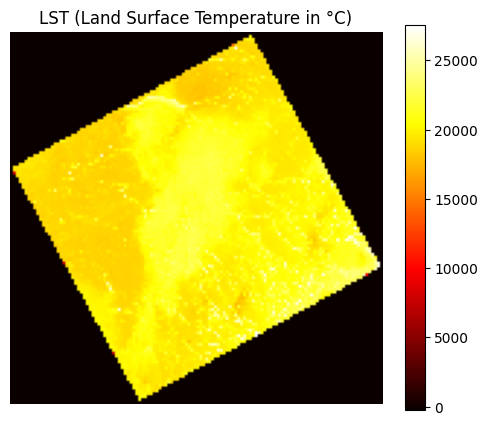

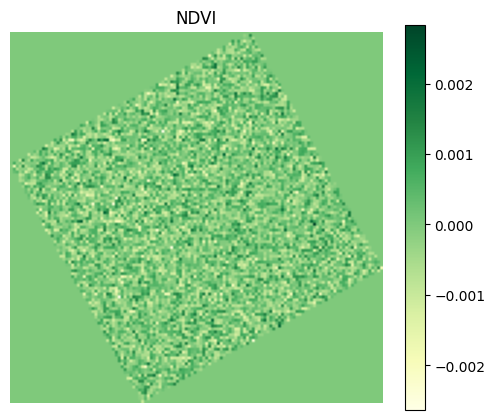

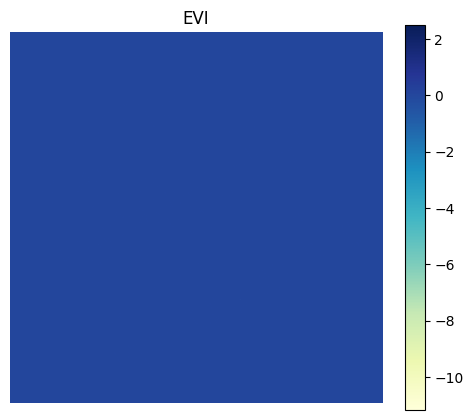

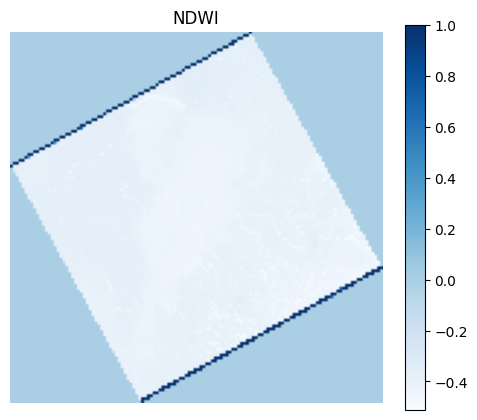

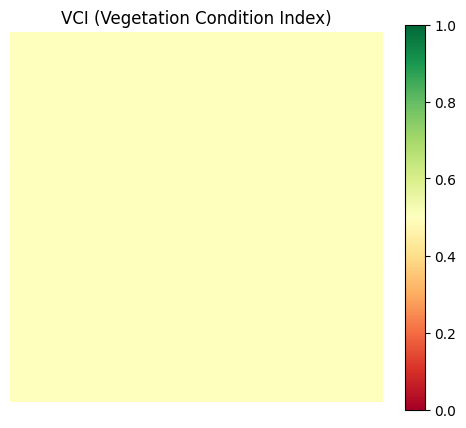

In [ ]:
def show_index(index, title, cmap='viridis'):
    plt.figure(figsize=(6, 5))
    plt.imshow(index, cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.axis('off')
    plt.show()

show_index(lst, "LST (Land Surface Temperature in °C)", cmap='hot')
show_index(ndvi, "NDVI", cmap='YlGn')
show_index(evi, "EVI", cmap='YlGnBu')
show_index(ndwi, "NDWI", cmap='Blues')
show_index(vci, "VCI (Vegetation Condition Index)", cmap='RdYlGn')

**COMPUTING GLCM TEXTURE FEATURE**

In [ ]:
from skimage.feature import graycomatrix, graycoprops
import cv2

def compute_glcm_map(image, patch_size=16):
    image = ((image - np.min(image)) / (np.max(image) - np.min(image)) * 255).astype(np.uint8)
    h, w = image.shape
    glcm_map = np.zeros_like(image, dtype=np.float32)

    for i in range(0, h - patch_size, patch_size):
        for j in range(0, w - patch_size, patch_size):
            patch = image[i:i+patch_size, j:j+patch_size]
            glcm = graycomatrix(patch, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
            contrast = graycoprops(glcm, 'contrast')[0, 0]
            glcm_map[i:i+patch_size, j:j+patch_size] = contrast

    return glcm_map

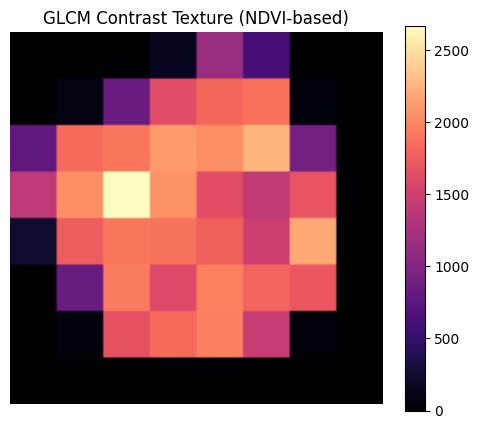

In [ ]:
glcm_texture = compute_glcm_map(ndvi)
show_index(glcm_texture, "GLCM Contrast Texture (NDVI-based)", cmap='magma')

**FEATURE STACKING AND LABEL GENERATION**

In [ ]:
import cv2

target_size = (128, 128)

ndvi = cv2.resize(ndvi, target_size)
ndwi = cv2.resize(ndwi, target_size)
lst  = cv2.resize(lst, target_size)

X = np.stack([ndvi, ndwi, lst], axis=-1)

In [ ]:
y = np.zeros_like(ndvi, dtype='uint8')
y[ndvi < 0.4] = 2
y[(ndvi >= 0.4) & (ndvi < 0.6)] = 1
y[ndvi >= 0.6] = 0

**TRAINING A DROUGHT CLASSIFIER**

In [ ]:
from sklearn.model_selection import train_test_split

X_flat = X.reshape(-1, 3)
y_flat = y.flatten()

X_train, X_test, y_train, y_test = train_test_split(X_flat, y_flat, test_size=0.2)

In [ ]:
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(3,)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=512)

Epoch 1/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4719 - loss: 4552.7539 - val_accuracy: 0.4635 - val_loss: 2182.0447
Epoch 2/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4969 - loss: 1439.7485 - val_accuracy: 1.0000 - val_loss: 9.6458e-08
Epoch 3/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00


**DROUGHT RISK MAP PREDICTION**

512/512 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


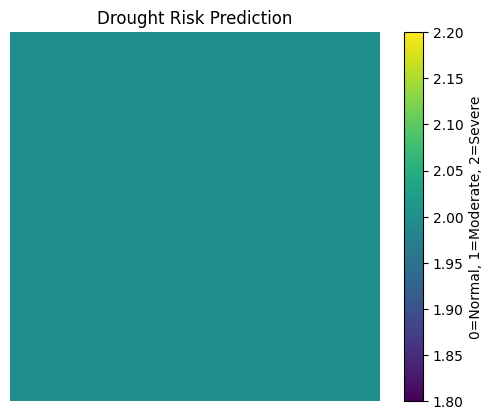

In [ ]:
y_pred = model.predict(X_flat).argmax(axis=-1)
pred_map = y_pred.reshape(target_size)

import matplotlib.pyplot as plt
plt.imshow(pred_map, cmap='viridis')
plt.title("Drought Risk Prediction")
plt.colorbar(label='0=Normal, 1=Moderate, 2=Severe')
plt.axis('off')
plt.show()

**Evaluation Metrics (Accuracy + IoU)**

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

print("Pixel Accuracy:", accuracy_score(y_flat, y_pred))

cm = confusion_matrix(y_flat, y_pred, labels=[0,1,2])
TP = cm[2,2]
FP = cm[:,2].sum() - TP
FN = cm[2,:].sum() - TP
iou_drought = TP / (TP + FP + FN + 1e-10)
print("Drought IoU (class=2):", round(iou_drought, 3))

Pixel Accuracy: 1.0
Drought IoU (class=2): 1.0
